In [13]:
import os
import sys
code_dir = os.path.split(os.getcwd())[0]
if code_dir not in sys.path:
    sys.path.append(code_dir)

In [14]:
import numpy as np
import pickle

# my code
from contrastive_divergence_optimiser import CDOptimiser
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise, ChowLiuTree
from latent_nce_optimiser import LatentNCEOptimiser
from latent_variable_model import RestrictedBoltzmannMachine
from utils import plot_rbm_log_likelihood_training_curves

from copy import deepcopy
from itertools import product
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from pandas import DataFrame
from pomegranate import BayesianNetwork

%matplotlib inline
rc('lines', linewidth=1)
rc('font', size=18)
rc('legend', fontsize=16)
rc('text', usetex=True)

# For reproducibility
rng = rnd.RandomState(1083463236)

In [15]:
exp_res_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/experimental-results/'
exp_name = 'partial-m-step-with-lbfgsb'
exp_dir = os.path.join(exp_res_dir, exp_name)

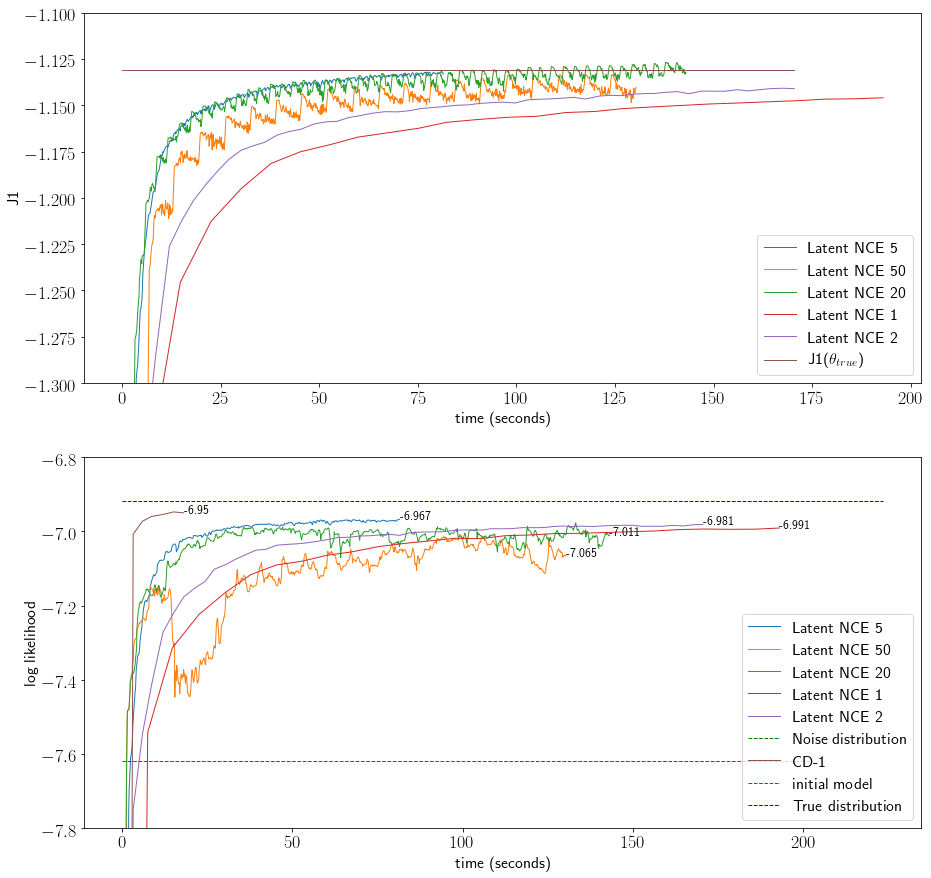

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
axs = axs.ravel()
#sorted_files = [str(file) for file in sorted([int(file) for file in os.listdir(exp_dir)])]
for i, file in enumerate(os.listdir(exp_dir)):
    exp = os.path.join(exp_dir, file)
    
    optimiser = pickle.load(open(os.path.join(exp, 'lnce_optimiser.p'), 'rb'))
    cd_optimiser = pickle.load(open(os.path.join(exp, 'cd_optimiser.p'), 'rb'))
    
    loaded_data = np.load(os.path.join(exp, 'data.npz'))
    loaded_truth = np.load(os.path.join(exp, 'true_weights_and_likelihood.npz'))
    loaded_init = np.load(os.path.join(exp, 'init_theta_and_likelihood.npz'))
    loaded_lnce = np.load(os.path.join(exp, 'lnce_results.npz'))
    loaded_cd = np.load(os.path.join(exp, 'cd_results.npz'))
    X = loaded_data['X']
    Y = loaded_data['Y']
    true_theta = loaded_truth['true_theta']
    true_log_like = loaded_truth['ll']
    theta0 = loaded_init['theta0']
    init_log_like = loaded_init['ll']
    lnce_thetas = loaded_lnce['params']
    J1s = loaded_lnce['J1s']
    lnce_times = loaded_lnce['times']
    av_log_like_lnce = loaded_lnce['ll']
    cd_thetas = loaded_cd['params']
    cd_times = loaded_cd['times']
    av_log_like_cd = loaded_cd['ll']
    
    ax = axs[0]
    ax.plot(lnce_times, J1s, label='Latent NCE {}'.format(file))
    ax.set_xlabel('time (seconds)', fontsize=16)
    ax.set_ylabel('J1', fontsize=16)

    ax = axs[1]
    ax.plot(lnce_times, av_log_like_lnce, label='Latent NCE {}'.format(file))
    axs[1].annotate(r"{}".format(round(av_log_like_lnce[-1], 3)), 
                    xy=(lnce_times[-1], av_log_like_lnce[-1]), fontsize=12)
    
optimal_J1 = optimiser.evaluate_J1_at_param(theta=true_theta.reshape(-1), X=X)
axs[0].plot((lnce_times[0], lnce_times[-1]), (optimal_J1, optimal_J1), 
        label=r'J1($\theta_{true}$)')

noise = MultivariateBernoulliNoise(np.mean(X, axis=0))
noise_log_like = np.mean(np.log(noise(X)))
axs[1].plot((0, plt.get(ax, 'xlim')[1]), (noise_log_like, noise_log_like),
                'g--', label='Noise distribution')
axs[1].plot(cd_times, av_log_like_cd, label='CD-1')
axs[1].plot((0, plt.get(ax, 'xlim')[1]), (init_log_like, init_log_like),
                    'r--', label='initial model')
axs[1].plot((0, plt.get(ax, 'xlim')[1]), (true_log_like, true_log_like),
                'b--', label='True distribution')

axs[1].annotate(r"{}".format(round(av_log_like_cd[-1], 3)), xy=(cd_times[-1], av_log_like_cd[-1]), fontsize=12)

axs[1].set_xlabel('time (seconds)', fontsize=16)
axs[1].set_ylabel('log likelihood', fontsize=16)
axs[0].set_ylim((-1.3, -1.10))
axs[1].set_ylim((-7.8, -6.80))
axs[0].legend()
_ = axs[1].legend(loc='lower right')

fig.savefig('/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/'
           'proposal/experiments/partial-m-step-with-lbfgsb/partial-em-comparison.pdf')